/opt/conda/envs/py_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import time
import psutil
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, EsmModel
import gc
import pandas as pd
from torch.cuda import memory_stats, memory_summary
import matplotlib.pyplot as plt

def generate_dummy_data(seq_length, batch_size):
    """Generate dummy protein sequences for testing."""
    vocab = list('ACDEFGHIKLMNPQRSTVWY')
    sequences = [''.join(np.random.choice(vocab, seq_length)) for _ in range(batch_size)]
    labels = torch.randint(0, 2, (batch_size,))
    return sequences, labels

def measure_gpu_memory():
    """Measure current GPU memory usage."""
    return {
        'allocated': torch.cuda.memory_allocated() / 1024**2,  # MB
        'cached': torch.cuda.memory_reserved() / 1024**2      # MB
    }


class ESMBenchmark:
    def __init__(self):
        self.models = {
            'esm2_t6_8M': 'facebook/esm2_t6_8M_UR50D',
            'esm2_t12_35M': 'facebook/esm2_t12_35M_UR50D',
            'esm2_t30_150M': 'facebook/esm2_t30_150M_UR50D',
            'esm2_t33_650M': 'facebook/esm2_t33_650M_UR50D',
            'esm2_t36_3B': 'facebook/esm2_t36_3B_UR50D',
            'esm1b_t33_650M': "facebook/esm1b_t33_650M_UR50S"
        }
        self.sequence_lengths = [128, 256, 512, 1024]
        self.batch_sizes = [2, 4, 8, 16, 32]
        self.results = []
    
    def benchmark_inference(self, model, tokenizer, sequences, batch_size):
        """Measure inference speed and memory."""
        inputs = tokenizer(sequences, return_tensors="pt", padding=True).to(device)
        
        # Measure memory before
        mem_before = measure_gpu_memory()
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(10):  # Run multiple times for more stable measurements
                _ = model(**inputs)
        end_time = time.time()

        torch.cuda.synchronize()
        
        # Measure memory after
        mem_after = measure_gpu_memory()
        
        return {
            'avg_time': (end_time - start_time) / 10,
            'memory_increase': mem_after['allocated'] - mem_before['allocated']
        }
    
    def benchmark_training(self, model, tokenizer, sequences, labels, batch_size):
        """Measure training speed and memory."""
        inputs = tokenizer(sequences, return_tensors="pt", padding=True).to(device)
        labels = labels.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        criterion = torch.nn.CrossEntropyLoss()
        
        # Measure memory before
        mem_before = measure_gpu_memory()
        
        # Measure training time
        start_time = time.time()
        for _ in range(5):  # Fewer iterations for training due to higher memory usage
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.pooler_output, labels)
            loss.backward()
            optimizer.step()

        torch.cuda.synchronize()
    
        end_time = time.time()
        
        # Measure memory after
        mem_after = measure_gpu_memory()
        
        return {
            'avg_time': (end_time - start_time) / 5,
            'memory_increase': mem_after['allocated'] - mem_before['allocated']
        }
    
    def run_benchmarks(self):
        """Run comprehensive benchmarks across models and configurations."""
        for model_name, model_path in self.models.items():
            print(f"\nBenchmarking {model_name}...")
            
            try:
                # Load model and tokenizer
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = EsmModel.from_pretrained(model_path).to(device)
                
                for seq_length in self.sequence_lengths:
                    for batch_size in self.batch_sizes:
                        try:
                            # Generate test data
                            sequences, labels = generate_dummy_data(seq_length, batch_size)
                            
                            torch.cuda.empty_cache()
                            gc.collect()
                            
                            # Run benchmarks
                            inf_metrics = self.benchmark_inference(model, tokenizer, sequences, batch_size)
                            train_metrics = self.benchmark_training(model, tokenizer, sequences, labels, batch_size)
                            
                            self.results.append({
                                'model': model_name,
                                'sequence_length': seq_length,
                                'batch_size': batch_size,
                                'inference_time': inf_metrics['avg_time'],
                                'inference_memory': inf_metrics['memory_increase'],
                                'training_time': train_metrics['avg_time'],
                                'training_memory': train_metrics['memory_increase']
                            })
                            
                        except RuntimeError as e:
                            print(f"Error with {model_name}, seq_length={seq_length}, batch_size={batch_size}: {e}")
                            continue
                
                # Clear model from GPU
                del model
                torch.cuda.empty_cache()
                gc.collect()
                
            except Exception as e:
                print(f"Error loading {model_name}: {e}")
                continue
    
    def plot_results(self):
        """Generate visualization of benchmark results."""
        df = pd.DataFrame(self.results)
        
        # Plot training time
        plt.figure(figsize=(15, 10))
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            plt.plot(model_data['sequence_length'], model_data['training_time'], label=model, marker='o')
        plt.xlabel('Sequence Length')
        plt.ylabel('Training Time (s)')
        plt.title('Training Time vs Sequence Length')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_time.png')
        
        # Plot memory usage
        plt.figure(figsize=(15, 10))
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            plt.plot(model_data['sequence_length'], model_data['training_memory'], label=model, marker='o')
        plt.xlabel('Sequence Length')
        plt.ylabel('Memory Usage (MB)')
        plt.title('Memory Usage vs Sequence Length')
        plt.legend()
        plt.grid(True)
        plt.savefig('memory_usage.png')
        
        return df

device = 'cuda:0'
benchmark = ESMBenchmark()
benchmark.run_benchmarks()
results_df = benchmark.plot_results()

# Save results to CSV
results_df.to_csv('esm_benchmark_results.csv', index=False)
print("\nBenchmark complete! Results saved to CSV and plots generated.")


Benchmarking esm2_t6_8M...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 320])
torch.Size([2, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 320])
torch.Size([2, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 320])
torch.Size([2, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 320])
torch.Size([2, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 320])
torch.Size([2, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 320])
torch.Size([4, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 320])
torch.Size([4, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 320])
torch.Size([4, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 320])
torch.Size([4, 130, 320])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 320])
torch.Size([4, 130, 320])
odict_keys(['last_hi

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Benchmarking esm2_t12_35M...
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 480])
torch.Size([2, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 480])
torch.Size([2, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 480])
torch.Size([2, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 480])
torch.Size([2, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 480])
torch.Size([2, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 480])
torch.Size([4, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 480])
torch.Size([4, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 480])
torch.Size([4, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 480])
torch.Size([4, 130, 480])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 480])
torch.Size([4, 1

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 640])
torch.Size([2, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 640])
torch.Size([2, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 640])
torch.Size([2, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 640])
torch.Size([2, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 640])
torch.Size([2, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 640])
torch.Size([4, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 640])
torch.Size([4, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 640])
torch.Size([4, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 640])
torch.Size([4, 130, 640])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 640])
torch.Size([4, 130, 640])
odict_keys(['last_hi

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 2560])
torch.Size([2, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 2560])
torch.Size([2, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 2560])
torch.Size([2, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 2560])
torch.Size([2, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 2560])
torch.Size([2, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 2560])
torch.Size([4, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 2560])
torch.Size([4, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 2560])
torch.Size([4, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 2560])
torch.Size([4, 130, 2560])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 2560])
torch.Size([4, 130, 2560])


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm1b_t33_650M_UR50S and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 1280])
torch.Size([2, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([4, 1280])
torch.Size([4, 130, 1280])


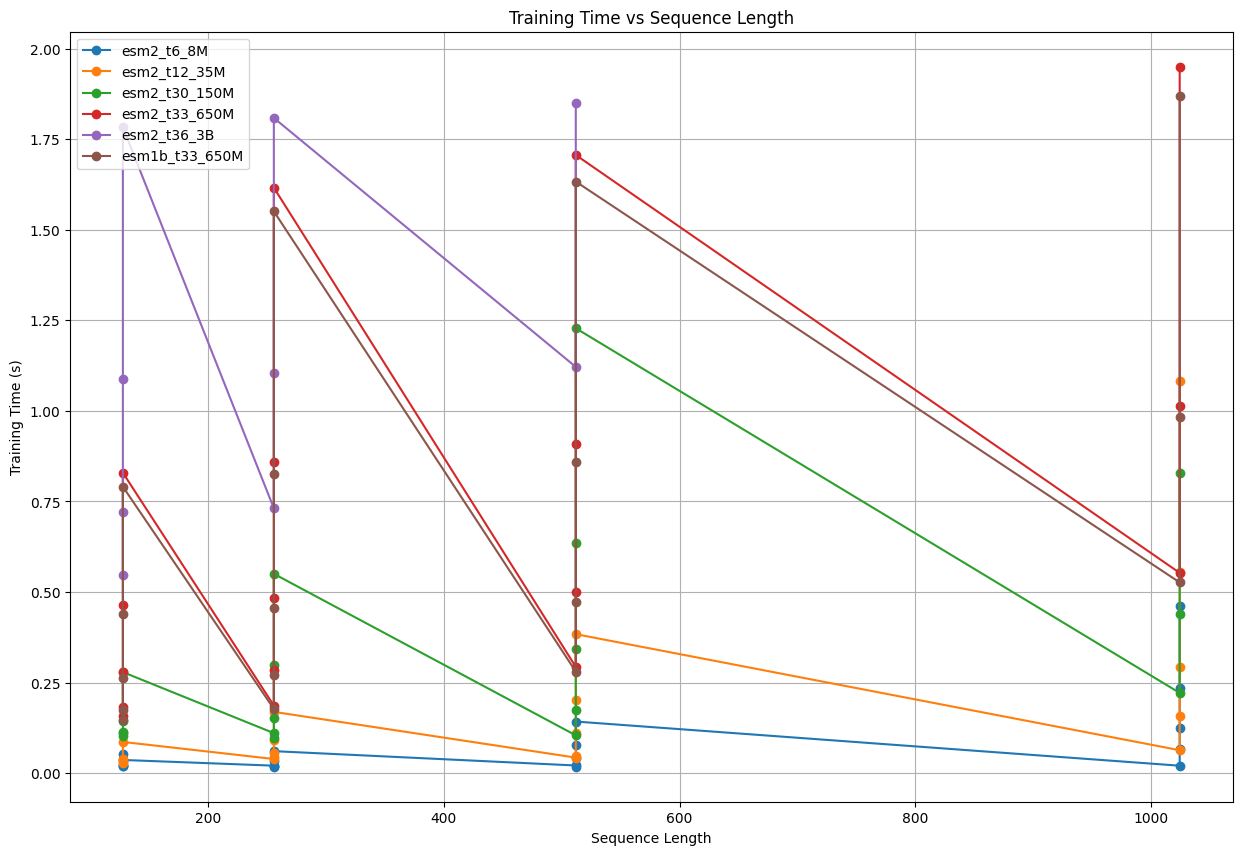

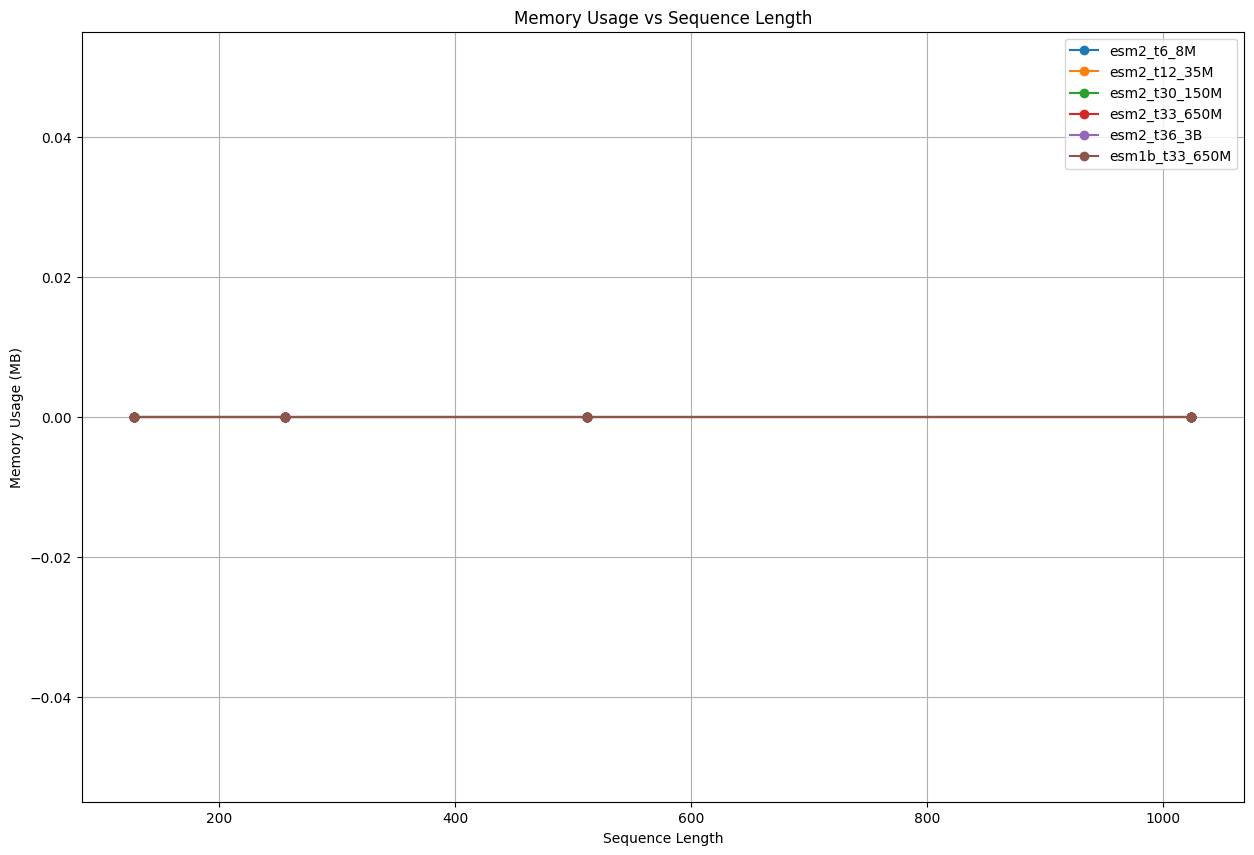